# Lookahead model 

Due to the complexity of the Empirical Bayes method and the distortion it creates for referrals at the end of the observation window we've chosen to use a simpler metric. 

For every referral we will be trying to predict the number of referrals in the following 12 months less the number of `breaks` defined as referral free periods longer than 28 days

First: Some imports

In [188]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, make_scorer
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec




from scipy.stats import beta, spearmanr, rankdata
from datetime import datetime

import sys
sys.path.append('../')
from scripts.model_utils import calc_look_ahead_stats

# Problem set-up
Load the data

In [2]:
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv')

clients = pd.read_csv('../../Welcome-Centre-DataCorps-Data/clients.csv', index_col=0)

referrals['ReferralTakenDate'] = pd.to_datetime(referrals['ReferralTakenDate'])
    
referrals = referrals.sort_values('ReferralTakenDate')

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
referrals = referrals.pipe(calc_look_ahead_stats, window=365, break_length=28, break_coefficient=1)

### Plot the time series and score for a single client 

In [233]:
# Plot the score for a single client
def plot_time_series(referrals, client_id):
    for_plot = referrals[(referrals['ClientId']==client_id)]
                         #& (referrals['weeks'] >= 52)]
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.plot_date(x=for_plot['ReferralTakenDate'], y=[1 for i in range(len(for_plot))])
    ax1.plot_date(x=for_plot['ReferralTakenDate'], y=for_plot['future_referral_score'])
    ax1.set_ylim(0,55)
    ax1.set_ylabel('Future Referral Score')


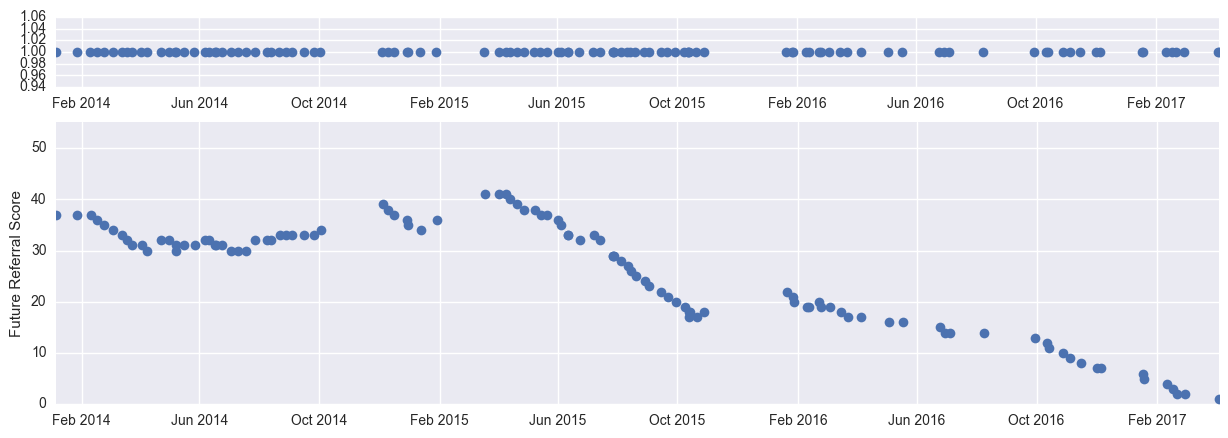

In [234]:
plot_time_series(referrals, 287)

### Build Scoring Function for Machine Learning Models 

We will use a top n% match as the scoring metric. This is defined as the fraction of the top n% worst referrals that we correctly predict.

e.g. if there are 100 referrals in the top 10% of future referral scores and we predict 20 of them correctly our model metric would be 0.2 (or 20%)

In [164]:
actual = np.random.randint(1,10,100)
predicted = np.random.randint(1,10,100)

In [165]:
compare = pd.DataFrame({'actual':actual, 'predicted':predicted})

In [174]:
compare['actual_rank'] = np.argsort(compare['actual'])
compare['predicted_rank'] = np.argsort(compare['predicted'])
compare['match'] = (compare['actual_rank'] >= 90) & (compare['predicted_rank'] >= 90)

In [175]:
compare['match'].sum()/(compare['actual_rank']>=90).sum()

0.29999999999999999

In [186]:
def top_n_match(actual, predicted, top_n_percent=10):
    actual_rank = np.argsort(actual)
    predicted_rank = np.argsort(predicted)
    cutoff = len(actual_rank)*(100-top_n_percent)/100
    corrects = (predicted_rank>=cutoff)&(actual_rank>=cutoff)
    count_correct = corrects.sum()
    score = count_correct / cutoff
    return score

top_n_scoring_function = make_scorer(top_n_match)

### Initial Model 

In [198]:
pipe = Pipeline([
    ('imp', Imputer()),
    ('scale', StandardScaler()),
    ('reg', Ridge())
])

In [214]:
def get_current_referral_issues(referrals):
    referral_reasons = referrals.filter(like='ReferralDomestic').add_prefix('reasons_')
    referral_document = referrals.filter(like='ReferralDocument').add_prefix('documents_')
    referral_benefit = referrals.filter(like='ReferralBenefit').add_prefix('benefit_')
    referral_issue = referrals.filter(like='ReferralIssue').add_prefix('r_issue_')
    referral_reason = referrals.filter(like='ReferralReason').add_prefix('reason_')
    client_issue = referrals.filter(like='ClientIssue').add_prefix('c_issue_')
    referral_agency = pd.get_dummies(referrals['ReferralAgencyId']).add_prefix('agency_')

    X = pd.concat([
        referral_reasons,
        referral_document,
        referral_benefit,
        referral_issue,
        referral_reason,
        referral_agency,
        client_issue
    ], axis=1).fillna(False).astype(bool)
    
    return X

subset = referrals[referrals['future_referral_score'].notnull()]

In [217]:
X = get_current_referral_issues(subset)

X['referral_no'] = X['referr']
y = subset['future_referral_score']

In [219]:
param_grid = {
    'reg__alpha': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring=top_n_scoring_function, verbose=3)
gs.fit(X, y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.014831 -   0.0s
[CV] reg__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ....................... reg__alpha=1e-05, score=0.008652 -   0.0s
[CV] reg__alpha=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV] ....................... reg__alpha=1e-05, score=0.010505 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.011741 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.015449 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.008034 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.013595 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.012977 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] ....................... reg__alpha=1e-05, score=0.009270 -   0.0s
[CV] reg__alpha=1e-05 ................................................
[CV] .

[CV] ........................ reg__alpha=10.0, score=0.012359 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] ........................ reg__alpha=10.0, score=0.011123 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] ........................ reg__alpha=10.0, score=0.011741 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] ........................ reg__alpha=10.0, score=0.011123 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] ........................ reg__alpha=10.0, score=0.013595 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] ........................ reg__alpha=10.0, score=0.009270 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] ........................ reg__alpha=10.0, score=0.012977 -   0.0s
[CV] reg__alpha=10.0 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   35.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg__alpha': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(top_n_match), verbose=3)

In [220]:
gs.best_score_

0.011742094171595257

In [222]:
predicted = gs.best_estimator_.predict(X)

In [223]:
top_n_match(y, predicted)

0.0099498797980359793

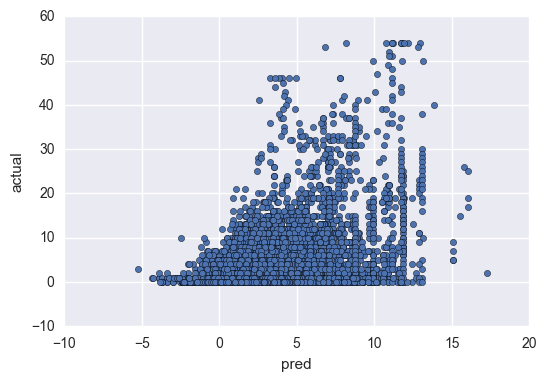

In [230]:
pd.DataFrame({'pred':predicted, 'actual':y}).plot(kind='scatter', x='pred', y='actual')